In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set_style("white")
sns.set_context("paper")
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Barcode distribution within 2 indipendet chromatin poolings (S2 cells)

In [5]:
%%bash

merged_fastq_folder="/data/deepseq/sequencing_data/191111_A00931_0028_AHH7JGDRXX_lanes1_2/Project_1146_Bella_DeepSeq"

### Extracts barcodes from merged input ###

for i in $merged_fastq_folder/Sample_19L005189/Input_60_BCs_rep_4_R1.fastq.gz; do zcat $i | awk '/^@/{getline;print}' | cut -c5-12 > ../intermediate_files/$(basename $i)_barcodes_R1.txt; done
for i in $merged_fastq_folder/Sample_19L005191/Rep_Input_60_BCs_rep_4_R1.fastq.gz; do zcat $i | awk '/^@/{getline;print}' | cut -c5-12 > ../intermediate_files/$(basename $i)_barcodes_R1.txt; done


Total number of barcodes: 60


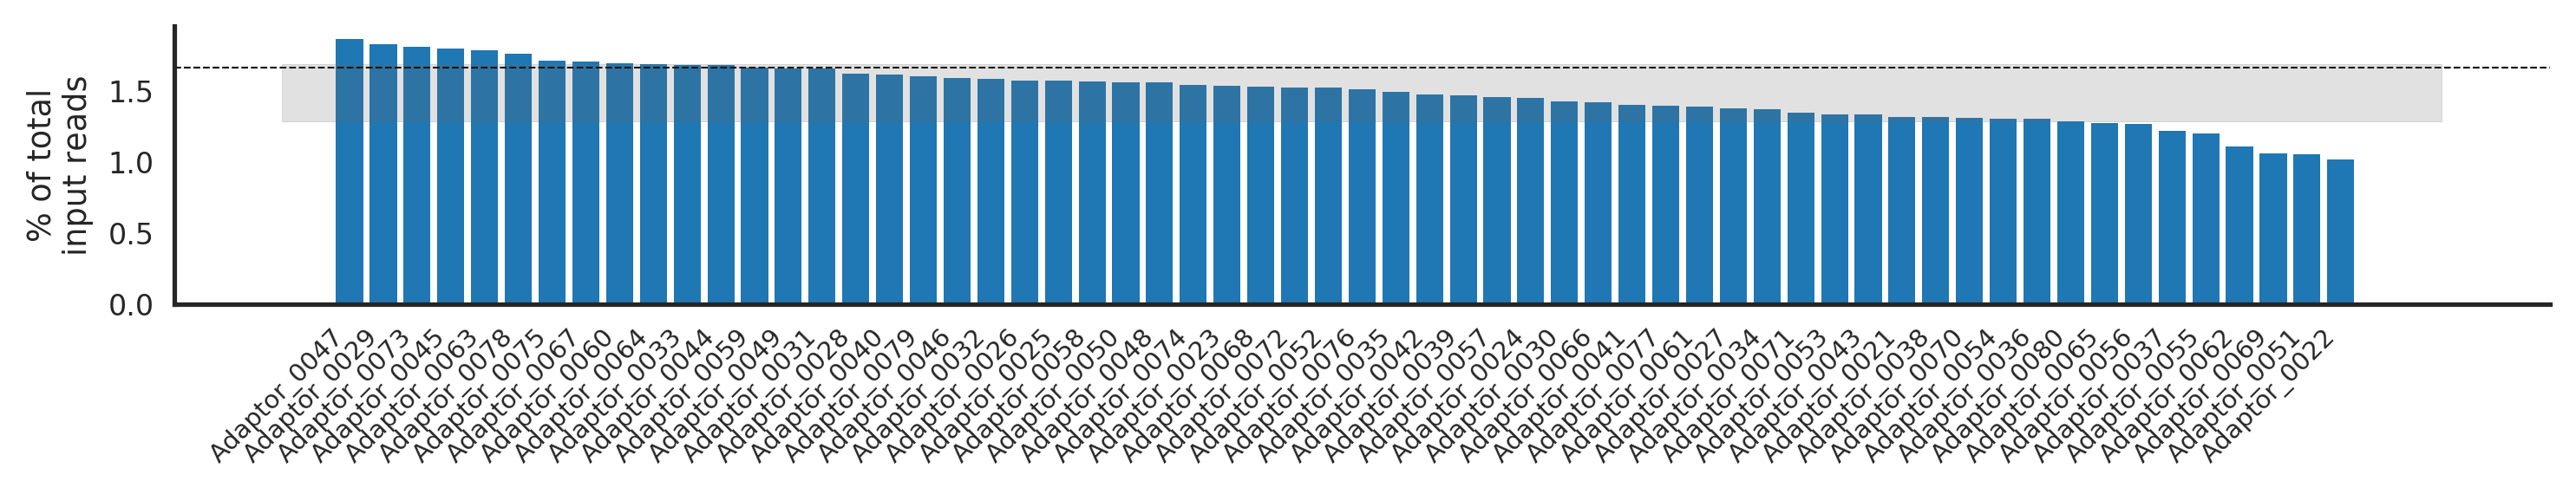

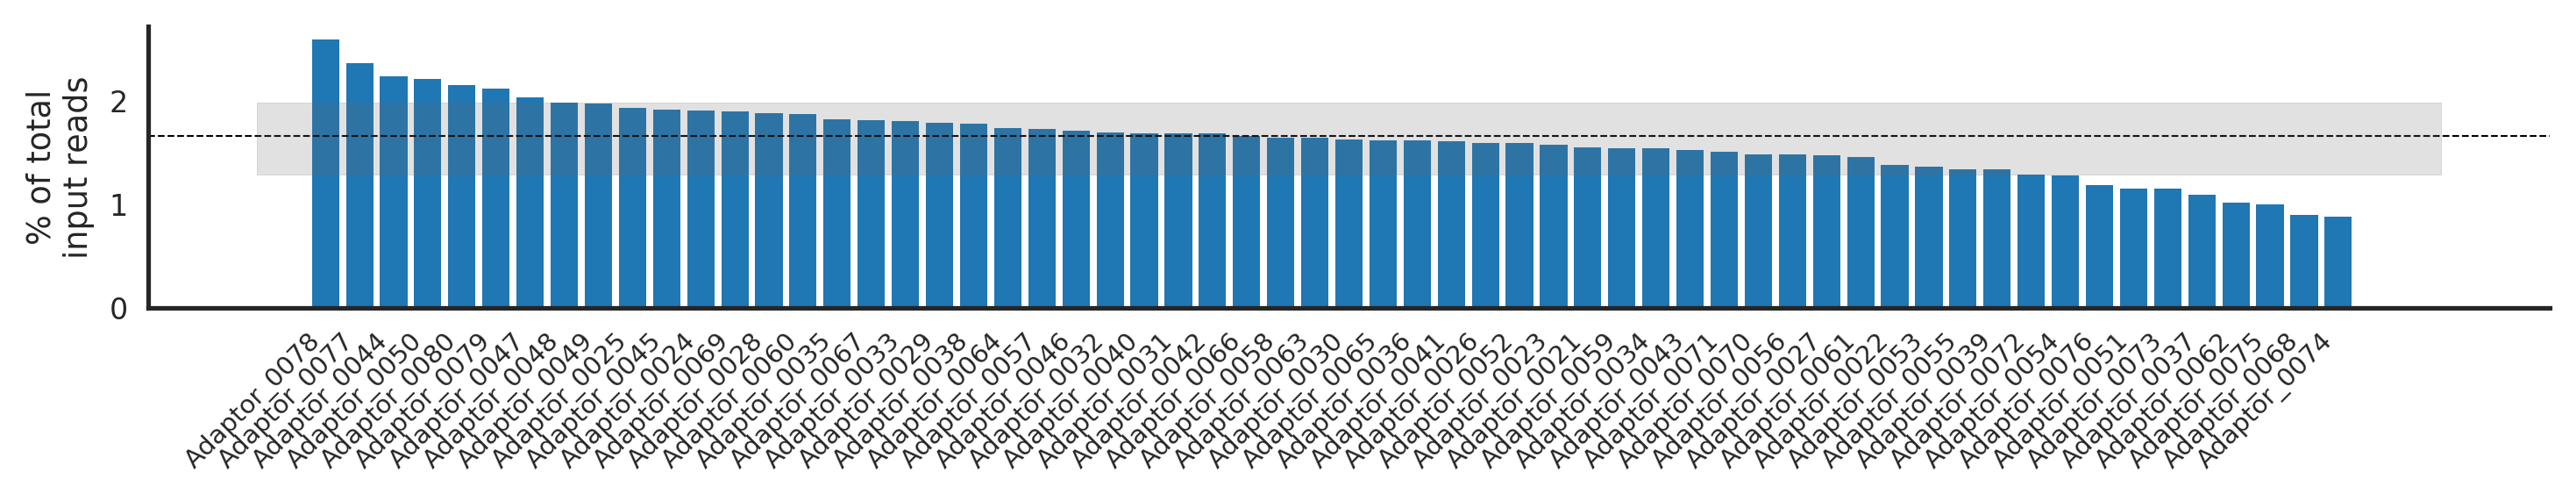

In [13]:
### read in barcodes metadata ###

list_barcodes = []
mapp = {}
with open("../input_data/1146_Bella_DeepSeq.txt") as inp:
    for line in inp:
        bc = line.strip().split()[1]
        sample = line.strip().split()[2]
        if not bc in list_barcodes:
            list_barcodes.append(bc)
            mapp[bc] = sample
        else:
            pass
print("Total number of barcodes: {}".format(len(list_barcodes)))



### count and plot ###

ranks = []
input_dir = "../intermediate_files"

for filename in os.listdir(input_dir):
    if filename.startswith("Input") or filename.startswith("Rep"):
        #count_line=0
        dixio={}
        with open(os.path.join(input_dir,filename)) as inp:
            for line in inp:
                #count_line+=1
                barcode = line.strip()
                if not barcode in dixio:
                    dixio[barcode] = 1
                else:
                    dixio[barcode]+=1
                    
        final_dixio={}
        sig_barcodes = {}
        for i in dixio:
            final_dixio[i] = dixio[i]/count_line
            if (dixio[i]/count_line)*100 > 0.1:
                sig_barcodes[i] = (dixio[i]/count_line)*100
                
        barcodes = []
        fraction = []
        gc_content = []
        for i in sig_barcodes:
            barcodes.append(i)
            fraction.append(sig_barcodes[i])
            gc_content.append(float(float(i.count("G")) + float(i.count("C")))/float(len(i)))
    
        fdf = pd.DataFrame({"barcodes":barcodes, "fraction":fraction, "gc_content":gc_content})
        fdf.sort_values(by="fraction", ascending=False, inplace=True)
        fdf["ID"] = ["_".join(mapp[i].split("_")[:2]) if i in mapp else i for i in fdf.barcodes]
        ranks.append(fdf)

        ### plot ###
        
        called_barcodes = []
        fig,ax = plt.subplots(dpi=300,figsize=(10,2))
        ax.bar(range(len(barcodes)), np.array(fdf.fraction))
        ax.set_xticks(range(len(barcodes)))
        ax.set_xticklabels(fdf.ID,rotation=45, ha="right", size=7)
        plt.ylabel("% of total\ninput reads")
        for i in range(len(list(fdf.barcodes))):
            if list(fdf.barcodes)[i] in list_barcodes:
                called_barcodes.append(list(fdf.barcodes)[i])
                #ax.get_xticklabels()[i].set_color("k")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        ax.axhline(100/60, linestyle="--", linewidth=0.5, color='k')
        
        xx = [-2,-1]+list(range(len(barcodes)))+[len(barcodes)+1,len(barcodes)+2]
        
        yy = fdf.fraction.copy()
        mmean = np.mean(yy)
        yy = (yy - (100/60))

        std = np.std(yy)
        ax.fill_between(xx, [mmean + std]*len(xx), [mmean - std]*len(xx), 
                        color='dimgrey', alpha=0.2, zorder=3)
        
        
        plt.tight_layout()
        plt.savefig("../figures/Barcode_integration_efficiency_{}.pdf".format(filename.split(".")[0]))